# My first neural network!
## ICE 2025 - Artificial Intelligence for O&G Without the Hype

<a href="https://colab.research.google.com/github/paduapires/aapg_ice/blob/main/numpy_MLP_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Pedro Pesce <<pedro_pesce@petrobras.com.br>>
- Thiago Toribio <<thiago.toribio@petrobras.com.br>>
- Cesar Calderon <<cjcalderon@petrobras.com.br>>
- Luiz Eduardo Queiroz <<eduardoqueiroz@petrobras.com.br>>
- Antonio de Padua Pires <<antonio.pires@petrobras.com.br>>

Image classification

In [70]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn.datasets as skdata
import sklearn.model_selection as skms
import sklearn.metrics as skm

import seaborn as sns

import time

## Loading the data

The DIGITS dataset is available through `sklearn.datasets`:

In [71]:
# Loading the data from DIGITS

digits = skdata.load_digits()

X = digits.data
y = digits.target

# Splitting data into training and validation
X_train, X_validation, y_train, y_validation = skms.train_test_split(X,y,train_size=0.7,random_state=42)

# Checking the size of the training and validation data
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((1257, 64), (1257,), (540, 64), (540,))

### Visualizing some examples

array([[ 0.,  2., 12., 13., 16., 16.,  4.,  0.],
       [ 0., 11., 16., 13.,  7.,  4.,  1.,  0.],
       [ 0., 13., 14.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., 15., 12.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  6., 16.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 13.,  7.,  0.,  0.,  0.],
       [ 0.,  3.,  5., 16.,  7.,  0.,  0.,  0.],
       [ 0.,  3., 13., 15.,  0.,  0.,  0.,  0.]])

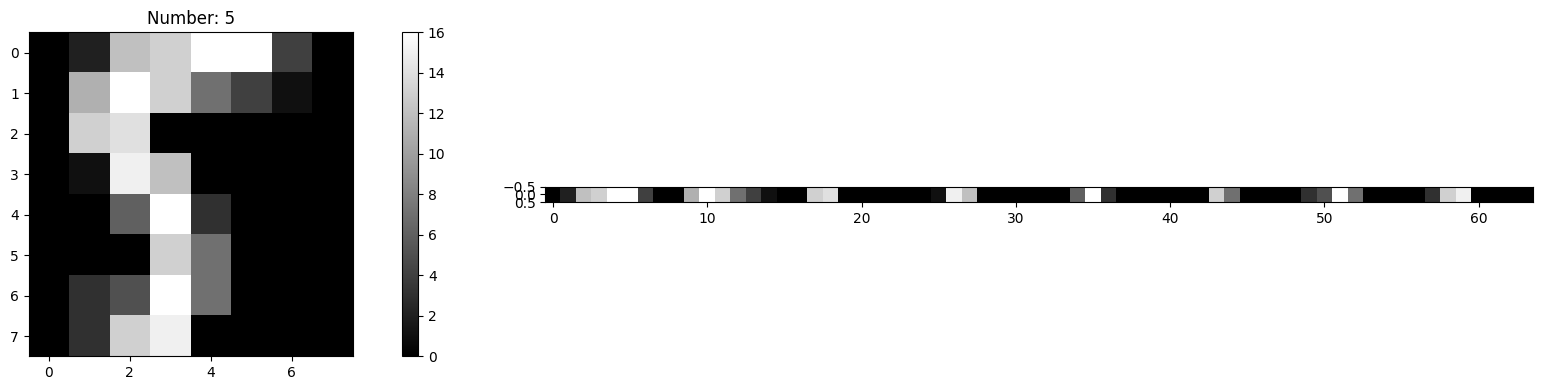

In [72]:
# Plot of some examples

ind = 801 # YOUR CODE HERE Choose an example to visualize
img = X[ind] + 0*np.random.randn(*X[ind].shape) # Add some noise?
img = img.reshape(8,8)

display(img)
fig,(ax0,ax1) = plt.subplots(1,2,figsize=(20,4))
CS = ax0.imshow(img, cmap='gray')
ax0.set_title(f'Number: {y[ind]}')
ax1.imshow(X[[ind]],cmap='gray')
plt.colorbar(CS,ax=ax0)
plt.tight_layout()
plt.show()

### Creating the model


Let's create a neural network that uses pixel intensities (64 **features**) to estimate the probability of each example belonging to one of 10 possible classes.

The simplest architecture for a neural network is the so-called **fully-connected network**, sometimes called a **multi-layer perceptron**. There are several possibilities for hyperparameter tuning of this type of network. In this notebook, we will use a single hidden layer with 100 neurons and a **ReLU** activation function, followed by another linear layer and a **softmax** probability normalization, as illustrated below.

<center><img src="https://github.com/paduapires/aapg_ice/blob/main/MLP.png?raw=1" align="center" width="40%"></center>

$$
\color{blue}X\color{red}W^{(1)}\color{black} + \color{red}B^{(1)}\color{black} = H^{(1)} \quad ; \quad ReLU(H^{(1)}) = A^{(1)} \quad ; \quad A^{(1)}\color{red}W^{(2)}\color{black}+\color{red}B^{(2)}\color{black} = H^{(2)} \quad ; \quad softmax(H^{(2)}) =\color{purple}{P}
$$

$$
\color{purple}{P} = softmax\Biggl(\underbrace{ \underbrace{ReLU\bigl(\underbrace{\color{blue}X\color{red}{W^{(1)}}+ \color{red}{B^{(1)}}}_{H^{(1)}}\bigr)}_{A^{(1)}}
\color{red}{W^{(2)}}+\color{red}{B^{(2)}}}_{H^{(2)}}\Biggr)
$$

where:

- $\color{blue}X$ is the data matrix, with $N$ rows (one for each example) and $64$ columns (one for each attribute). It represents the model's <span style="color:blue">**inputs**</span>;
- $\color{red}{W^{(1)}}$, $\color{red}{B^{(1)}}$, $\color{red}{W^{(2)}}$, $\color{red}{B^{(2)}}$ are the adjustable <span style="color:red">**parameters**</span> of the network (**weights** and **biases**);
- $H^{(1)}, A^{(1)}, H^{(2)}$ are intermediate values computed by the network. They are hidden, or **latent**. $H^{(2)}$ in particular, being the inputs to the final softmax normalization, are also called the network's **logits**;
- $\displaystyle{ ReLU(h_{ij}^{(1)}) = max(0,h_{ij}^{(1)}) = \begin{cases} h_{ij}^{(1)}&, h_{ij}^{(1)}\geq 0 \\ 0&, h_{ij}^{(1)}\le 0 \end{cases} \, \, }$  is the **activation function** chosen for the hidden layer, which operates element-wise;
- $\displaystyle{ softmax(h^{(2)}_{ij}) = \dfrac{e^{h^{(2)}_{ij}}}{\displaystyle \sum_je^{h^{(2)}_{ij}}} }$ is the final **activation function**, which normalizes each row of **logits** and outputs the probabilities matrix the $\color{purple}{P}$, such that all output probabilities are positive and sum to $1$ for each example. This is a generalization of the sigmoid function;
- Each element $\color{purple}{p_{ij}}$ of the network output is the estimated probability that example $i$ belongs to class $j$.

In [73]:
def softmax(X,axis=-1):
    '''Softmax along a given axis'''
    X_reg = X - X.max(axis=axis,keepdims=True) # Subtracting the maximum value to stabilize the exponentials
    eX = np.exp(X_reg)
    return eX/eX.sum(axis=axis,keepdims=True)

def rede(W1,B1,W2,B2,X,full_out=False):
    '''MLP-type network with 1 hidden layer, ReLU activation, and softmax output:

       W1,B1       ReLU       W2,B2     softmax
    X -------> H1 ------> A1 -------> H2 -----> P

     Inputs:
    - W1, B1, W2, B2: network parameters
    - X: input data matrix. One example per row, one feature per column.
    - full_out: False (default) - returns only the output probability matrix.
                True - also returns intermediate values H2, A1, H1. Useful for gradient calculation.

    Outputs:
    - P: probability matrix. One example per row, one class per column.
    or
    - P, H2, A1, H1: probability matrix and intermediate values.'''

    H1 = X@W1 + B1 # YOUR CODE HERE to apply the first linear layer on inputs X
    A1 = np.maximum(0,H1) # YOUR CODE HERE for the ReLU activation function
    H2 = A1@W2 + B2 # YOUR CODE HERE to apply the second linear layer on activations A1
    P  = softmax(H2) # YOUR CODE HERE to obtain the probabilities
    if full_out:
        return P, H2, A1, H1
    else:
        return P

## Parameter initialization

Each linear layer has a weight matrix $W$ and a bias vector $B$, known as the parameters of the network. These parameters are typically initialized with small random values, according to various heuristics. We will use the default behavior of PyTorch, with weights randomly and uniformly distributed in the interval $\left(-\dfrac{1}{\sqrt{N_{\text{inputs}}}}, \dfrac{1}{\sqrt{N_{\text{inputs}}}}\right)$:

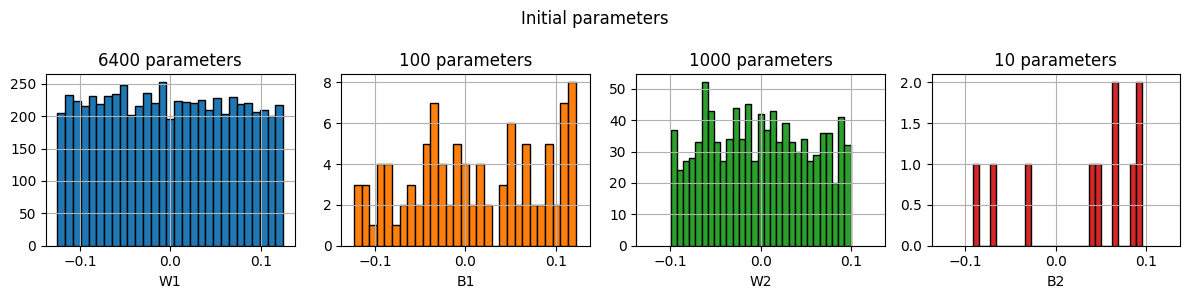

In [74]:
# Initializing the network weights and biases
np.random.seed(77)
size_input = X.shape[1]  # YOUR CODE HERE for the number of input features
size_H = 100  # YOUR CODE HERE for the hidden layer size
size_output = 10 # YOUR CODE HERE for the number of classes

# Initializing with zero-mean uniform random numbers
W1 = (np.random.rand(size_input, size_H)-0.5) * 2/np.sqrt(size_input)  # YOUR CODE HERE for the correct size of the parameters
B1 = (np.random.rand(            size_H)-0.5) * 2/np.sqrt(size_input)  # YOUR CODE HERE for the correct size of the parameters
W2 = (np.random.rand(size_H,size_output)-0.5) * 2/np.sqrt(size_H)      # YOUR CODE HERE for the correct size of the parameters
B2 = (np.random.rand(       size_output)-0.5) * 2/np.sqrt(size_H)      # YOUR CODE HERE for the correct size of the parameters

fig,axs = plt.subplots(1,4,sharex='all',figsize=(12,3))
for i,(par,par_name,ax) in enumerate(zip([W1, B1, W2, B2],['W1', 'B1', 'W2', 'B2'],axs.flat)):
    ax.hist(par.ravel(),bins=29,color='C'+str(i),edgecolor='k')
    ax.set_title(f'{par.size} parameters')
    ax.set_xlabel(par_name)
    ax.grid()
fig.suptitle('Initial parameters')
fig.tight_layout()

### Objective function

For classification problems, **categorical cross-entropy** is the most commonly used objective function.

$$
L = \textrm{x-entropy}\bigl(\color{purple}{P},Y\bigr) = -\dfrac{1}{N_{\text{examples}}} \sum_i^{N_{\text{examples}}} \sum_j^{N_{\text{classes}}} y_{ij} \ln\left(\color{purple}{p_{ij}}\right)
$$

where $y_{ij}$ is $1$ if example $i$ belongs to class $j$, and $0$ otherwise.

Note that this is equivalent to taking the average of $-\ln(p_{ij})$ only over the probabilities estimated by the model for the true class. This is a generalization of the previously studied binary cross-entropy function.

In [75]:
# Creating the loss function (cross-entropy - classification)
def cross_entropy(y_pred,y):
    return -np.mean( np.log( np.take_along_axis(y_pred,y[:,None],axis=-1) ) )

### Optimization

There are several possible optimization methods, but we will proceed with gradient based methods. For this, we need to compute the gradient of the objective function with respect to each network parameter, that is:

$$
\dfrac{\partial L}{\partial \color{red}{W^{(1)}}} \, ; \, \dfrac{\partial L}{\partial \color{red}{B^{(1)}}} \, ; \, \dfrac{\partial L}{\partial \color{red}{W^{(2)}}} \, ; \, \dfrac{\partial L}{\partial \color{red}{B^{(2)}}}
$$

These matrix derivatives are arranged in the same shape as the parameters in relation to which the derivative is calculated, that is, $\dfrac{\partial L}{\partial \color{red}{W^{(1)}}}$ is the same shape as $\color{red}{W^{(1)}}$,  $\dfrac{\partial L}{\partial \color{red}{B^{(1)}}}$ is the same shape as $\color{red}{B^{(1)}}$, etc.

The chain rule allows us to obtain these values:


$$
\color{blue}X\color{red}W^{(1)}\color{black} + \color{red}B^{(1)}\color{black} = H^{(1)} \quad ; \quad ReLU(H^{(1)}) = A^{(1)} \quad ; \quad A^{(1)}\color{red}W^{(2)}\color{black}+\color{red}B^{(2)}\color{black} = H^{(2)} \quad ; \quad softmax(H^{(2)}) =\color{purple}{P}
$$

$$
L = \textrm{x-entropy}\Biggl(\underbrace{softmax\biggl(\underbrace{ \underbrace{ReLU\bigl(\underbrace{\color{blue}X\color{red}{W^{(1)}}+ \color{red}{B^{(1)}}}_{H^{(1)}}\bigr)}_{A^{(1)}}
\color{red}{W^{(2)}}+\color{red}{B^{(2)}}}_{H^{(2)}}\biggr)}_{\color{purple}{P}},Y\Biggr)
$$

$$\begin{align}
\dfrac{\partial L}{\partial H^{(2)}} &= \underbrace{\color{purple}{P}-Y}_{\textrm{error}} \\
\dfrac{\partial L}{\partial \color{red}{B^{(2)}}} &= \dfrac{\partial L}{\partial H^{(2)}} \underbrace{\dfrac{\partial H^{(2)}}{\partial \color{red}{B^{(2)}}}}_{1} &
\dfrac{\partial L}{\partial \color{red}{W^{(2)}}} &= \dfrac{\partial L}{\partial H^{(2)}} \underbrace{\dfrac{\partial H^{(2)}}{\partial \color{red}{W^{(2)}}}}_{A^{(1)}} \\
\dfrac{\partial L}{\partial A^{(1)}} &= \dfrac{\partial L}{\partial H^{(2)}} \underbrace{\dfrac{\partial H^{(2)}}{\partial A^{(1)}}}_{{\color{red}{W^{(2)}}}^T} \\
\dfrac{\partial L}{\partial H^{(1)}} &= \dfrac{\partial L}{\partial A^{(1)}} \underbrace{\dfrac{\partial A^{(1)}}{\partial H^{(1)}}}_{u(H^{(1)})} \\
\dfrac{\partial L}{\partial \color{red}{B^{(1)}}} &= \dfrac{\partial L}{\partial H^{(1)}} \underbrace{\dfrac{\partial H^{(1)}}{\partial \color{red}{B^{(1)}}}}_{1} &
\dfrac{\partial L}{\partial \color{red}{W^{(1)}}} &= \dfrac{\partial L}{\partial H^{(1)}} \underbrace{\dfrac{\partial H^{(1)}}{\partial \color{red}{W^{(1)}}}}_{\color{blue}{X}} \\
\end{align}
$$

where for simplicity we omitted the fact that some of these products are matrix products, some are outer products and some are element-wise products. For a more step-by-step derivation of these results, see [https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf]


In [76]:
def grad(X,y,y_pred,H2,A1,H1,W1,B1,W2,B2):
    '''Gradient of L for the neural network.
    Receives everything as input, to avoid having to perform the forward pass again.

    Expected dimensions for each input:

    X      [n_batch, n_in] : Input matrix
    y      [n_batch]       : label vector
    y_pred [n_batch, n_out]: Matrix with estimated probabilities
    H1     [n_batch, n_H  ]  ;  W1 [n_in,  n_H ] ; B1 [n_H] : first linear layer
    A1     [n_batch, n_H  ]  : activations
    H2     [n_batch, n_out]  ;  W2 [n_H , n_out] ; B2 [n_out] : second linear layer

       W1,B1       ReLU       W2,B2      softmax      cross-entropy
    X -------> H1 ------> A1 -------> H2 ------> y_pred --------> L

    Outputs:
     - dLdW1  [n_in,  n_H ]
     - dLdB1  [n_H]
     - dLdW2  [n_H , n_out]
     - dLdB2  [n_out]
    '''

    n_batch,n_out = y_pred.shape
    n = np.arange(0,n_batch*n_out,n_out) # for linear indexing
    Err = y_pred.copy() # [n_batch,n_out] # initializing the error matrix
    Err.flat[n+y] -= 1  # subtracting 1 from the true classes

    dLdH2  = Err   # [n_batch, n_out]
    dH2dB2 = 1     # [n_out]
    dH2dW2 = A1    # [n_batch, n_H]
    dH2dA1 = W2.T  # [n_out  , n_H]
    dA1dH1 = H1>0  # [n_batch, n_H]
    dH1dB1 = 1     # [n_H]
    dH1dW1 = X     # [n_batch, n_in]
    dH1dX  = W1.T  # [n_H    , n_in]  (unnecessary)

    dLdB2 = dLdH2 * dH2dB2  # [n_batch, n_out] * [n_out] -> [n_batch, n_out]
    dLdW2 = dLdH2[:,None,:]*dH2dW2[:,:,None] # [n_batch, 1, n_out] * [n_batch, n_H, 1] -> [n_batch, n_H, n_out]

    dLdA1  = dLdH2 @ dH2dA1  # [n_batch, n_out] @ [n_out, n_H] -> [n_batch, n_H]
    dLdH1  = dLdA1 * dA1dH1  # [n_batch, n_H] * [n_batch, n_H] -> [n_batch, n_H ]

    dLdB1 = dLdH1 * dH1dB1 # [n_batch, n_H] * [n_H] -> [n_batch, n_H]
    dLdW1 = dLdH1[:,None,:] * dH1dW1[:,:,None] # [n_batch, 1, n_H] * [n_batch, n_in, 1] -> [n_batch, n_in, n_H]

    return dLdW1.mean(axis=0), dLdB1.mean(axis=0), dLdW2.mean(axis=0), dLdB2.mean(axis=0) # taking the average over the batch

### Learning Loop (Optimization)

The process of searching for the best values of weights occurs in the learning loop. This consists of some basic steps:

> 1) *Forward* stage:
> > - Computation of the estimated outputs for a set of inputs
> > - Computation of the loss function
> 2) *Backward* stage:
> > - Computation of the gradient of the cost function with respect to each weight and bias
> 3) Learning stage:
> > - Update of weights and biases

In this example, we will use gradient descent with a learning rate `lr=0.04`.

Parameter updates can be done at different frequencies:
- Once for every example: **stochastic gradient descent** (SGD), or **online** gradient descent;
- Once every `n_batch` examples: **mini-batch gradient descent**, frequently (but incorrectly) called stochastic gradient descent;
- Once per epoch:  (classical, **batch** or **full-batch**) gradient descent.

While **full-batch** gradient descent performs only one (computationally expensive) update per **epoch** (one complete pass through all training examples), stochastic and mini-batch gradient descent allow for several (computationally cheaper, but noisy) parameter updates per **epoch**, usually achieving faster training times.

In [77]:
# Initializing empty lists
loss_train_vanilla = []
loss_train_augmented = []
loss_validation  = []

epoch = 0

In [78]:
data_augmentation = False # add noise to training examples?
batches = 1 # full-batch (1) or mini-batch (6, for example)

start = time.time()
max_epochs = 150
lr = 0.04
n_batch = int(np.ceil(X_train.shape[0]/batches))
for i_epoch in range(1,max_epochs+1):
    l_vanilla = 0 # initializing for the epoch
    l_augmented = 0
    for ind in range(0,X_train.shape[0],n_batch): # mini batches
        X_batch = X_train[ind:ind+n_batch]
        y_batch = y_train[ind:ind+n_batch]

        # 1) Forward pass
        y_pred,H2,A1,H1 = rede(W1,B1,W2,B2,X_batch,full_out=True) # computes y_predicted (and likely errs)
        X_grad = X_batch # X to use in the gradient calculation
        l_vanilla += cross_entropy(y_pred, y_batch) # compares the prediction with the true label

        if data_augmentation:
            X_augmented = X_batch + 3.0*np.random.randn(*X_batch.shape) # Data augmentation?
            y_pred,H2,A1,H1 = rede(W1,B1,W2,B2,X_augmented,full_out=True) # adding noise (data augmentation)
            X_grad = X_augmented #  X to use in the gradient calculation
            l_augmented += cross_entropy(y_pred, y_batch) # compares the prediction with the true label

        # 2) Backward pass: calculating the gradients
        dW1, dB1, dW2, dB2 = grad(X_grad,y_batch,y_pred,H2,A1,H1,W1,B1,W2,B2)

        # 3) Updating the parameters
        W1 -= lr*dW1
        B1 -= lr*dB1
        W2 -= lr*dW2
        B2 -= lr*dB2
    loss_train_vanilla.append(l_vanilla/batches)
    loss_train_augmented.append(l_augmented/batches) # Saving for posterity

    # Checking the performance on the validation set
    y_pred = rede(W1,B1,W2,B2,X_validation)
    l_validation = cross_entropy(y_pred, y_validation)
    loss_validation.append(l_validation)
    if ((epoch+i_epoch)%50) == 0 or i_epoch in [0,max_epochs]:
        end = time.time()
        t = end-start
        print(f'Epoch {epoch+i_epoch:4d}: Loss Train augmented {loss_train_augmented[-1]:.5f}; Loss Train vanilla {loss_train_vanilla[-1]:.5f}; Loss Validation {loss_validation[-1]:.5f}; Time {t:.5f}s')
        start = time.time()
epoch += max_epochs

Epoch   50: Loss Train augmented 0.00000; Loss Train vanilla 0.17377; Loss Validation 0.18626; Time 2.70491s
Epoch  100: Loss Train augmented 0.00000; Loss Train vanilla 0.09965; Loss Validation 0.13017; Time 2.69752s
Epoch  150: Loss Train augmented 0.00000; Loss Train vanilla 0.06988; Loss Validation 0.11119; Time 3.23621s


### Visualizing the training progress

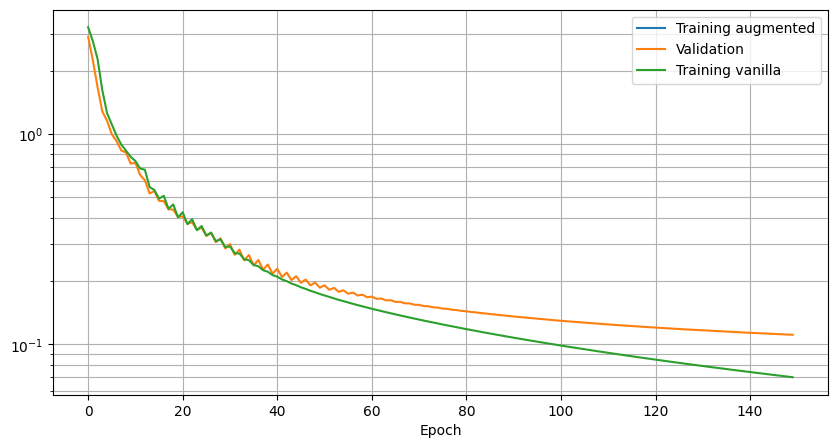

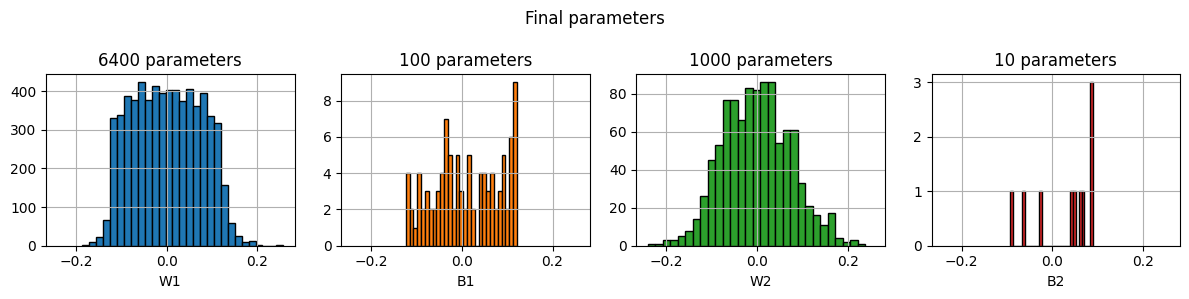

In [79]:
plt.figure(figsize=(10,5))
plt.semilogy(loss_train_augmented, label='Training augmented')
plt.plot(loss_validation, label='Validation')
plt.plot(loss_train_vanilla, label='Training vanilla')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('')
plt.grid(which='both')
plt.show()

fig,axs = plt.subplots(1,4,sharex='all',figsize=(12,3))
for i,(par,par_name,ax) in enumerate(zip([W1, B1, W2, B2],['W1', 'B1', 'W2', 'B2'],axs.flat)):
    ax.hist(par.ravel(),bins=29,color='C'+str(i),edgecolor='k')
    ax.set_title(f'{par.size} parameters')
    ax.set_xlabel(par_name)
    ax.grid()
fig.suptitle('Final parameters')
fig.tight_layout()

## Data augmentation

ML models tend to **generalize** better when trained on more diverse examples. However, it is not always feasible to get more training data, either because data is not available, or, more commonly, available data is not labeled. Strategies which we can use to diversify the used training data include generating **synthetic data** from scratch and modifying existing training data, called **data augmentation**.

Common augmentation techniques include **noise injection**, **geometric transformations** (mirroring, rotating, deforming images, etc), **frequency filtering**, **color transformations**, among others. The choice of data augmentation strategies is heavily domain specific, and must be carefully guided by the **domain expert** to ensure the training data diversity while  still closely matching real world data.

As an example, mirroring, rotating and flipping medical microscopy images upside down are all valid data augmentation strategies. However, for seismic images, only mirroring and small rotations would still look like real world data.

### Model performance on the training set

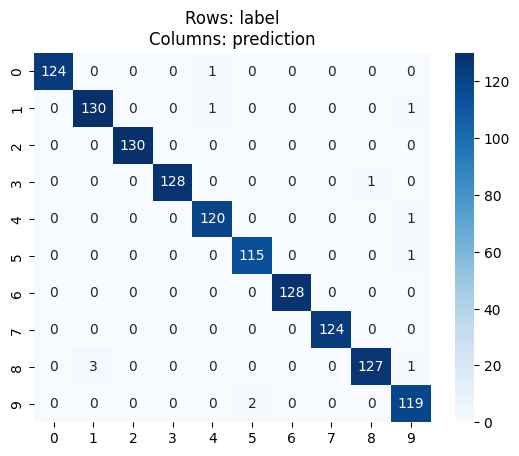

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       125
           1       0.98      0.98      0.98       132
           2       1.00      1.00      1.00       130
           3       1.00      0.99      1.00       129
           4       0.98      0.99      0.99       121
           5       0.98      0.99      0.99       116
           6       1.00      1.00      1.00       128
           7       1.00      1.00      1.00       124
           8       0.99      0.97      0.98       131
           9       0.97      0.98      0.98       121

    accuracy                           0.99      1257
   macro avg       0.99      0.99      0.99      1257
weighted avg       0.99      0.99      0.99      1257



In [80]:
py_pred = rede(W1,B1,W2,B2,X_train) # estimated class probabilities for the TRAINING set

y_pred = np.argmax(py_pred, axis=1) # most likely class for each example
labels = np.arange(py_pred.shape[-1]) # class sequence

cm = skm.confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=cm, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Rows: label\nColumns: prediction')
plt.show()

crep = skm.classification_report(y_train, y_pred, zero_division=0)
print(crep)

### Model evaluation on the validation set

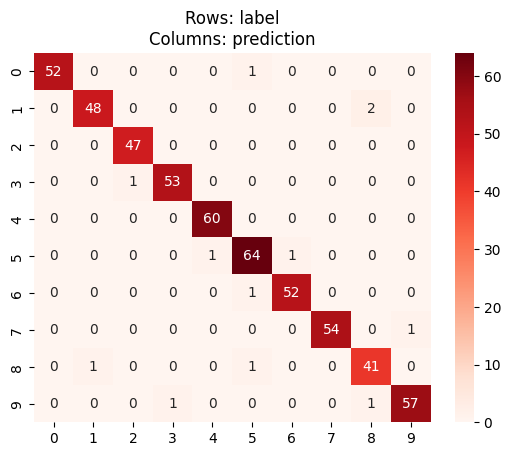

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        53
           1       0.98      0.96      0.97        50
           2       0.98      1.00      0.99        47
           3       0.98      0.98      0.98        54
           4       0.98      1.00      0.99        60
           5       0.96      0.97      0.96        66
           6       0.98      0.98      0.98        53
           7       1.00      0.98      0.99        55
           8       0.93      0.95      0.94        43
           9       0.98      0.97      0.97        59

    accuracy                           0.98       540
   macro avg       0.98      0.98      0.98       540
weighted avg       0.98      0.98      0.98       540



In [81]:
py_pred = rede(W1,B1,W2,B2,X_validation) # YOUR CODE HERE for estimated probabilities on the VALIDATION set

y_pred = np.argmax(py_pred, axis=1) # YOUR CODE HERE for the most likely class for each example

cm = skm.confusion_matrix(y_validation, y_pred)
sns.heatmap(cm, annot=cm, cmap='Reds', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Rows: label\nColumns: prediction')
plt.show()

crep = skm.classification_report(y_validation, y_pred, zero_division=0)
print(crep)

### Visualization of incorrect predictions

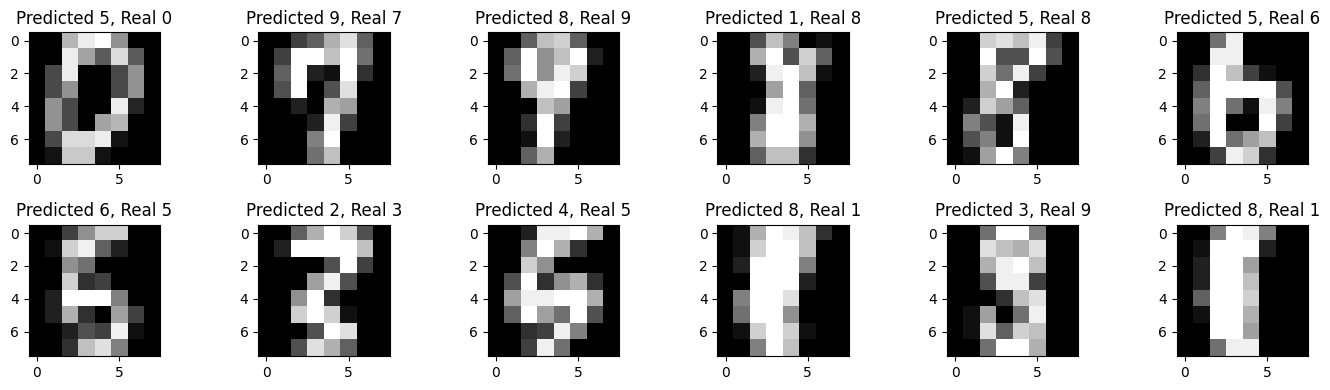

In [82]:
y_err  = y_pred[y_pred != y_validation] # incorrect predictions
yr_err = y_validation[y_pred != y_validation] # true values of incorrect predictions
X_err  = X_validation[y_pred != y_validation] # incorrect predictions image


plt.figure(figsize=(14,4))
n_wrong = X_err.shape[0]
nrow = 2
ncol = int(np.ceil(n_wrong/nrow))
for ind in range(n_wrong):
    plt.subplot(nrow,ncol,ind+1)
    plt.imshow(X_err[ind].reshape(8,8),cmap='gray')
    plt.title(f'Predicted {y_err[ind]}, Real {yr_err[ind]}')
plt.tight_layout()
plt.show()

### Drawing a new number for inference

0:0.000  ;  1:0.000  ;  2:0.888  ;  3:0.072  ;  4:0.000  ;  5:0.002  ;  6:0.000  ;  7:0.028  ;  8:0.001  ;  9:0.008  ;  

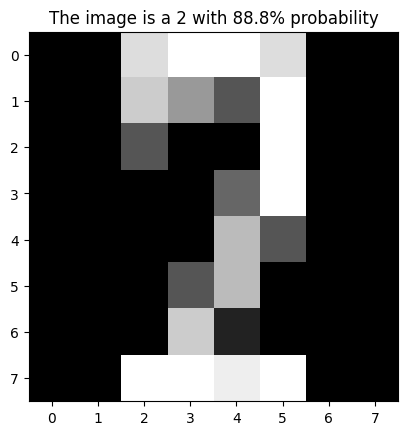

In [83]:
# Draw a digit here, with intensities between 0 and 15
my_num = np.array([ 00., 00., 13., 15., 15., 13., 00.,  00.,
                    00., 00., 12., 09., 05., 15., 00.,  00.,
                    00., 00., 05., 00., 00., 15., 00.,  00.,
                    00., 00., 00., 00., 06., 15., 00.,  00.,
                    00., 00., 00., 00., 11., 05., 00.,  00.,
                    00., 00., 00., 05., 11., 00., 00.,  00.,
                    00., 00., 00., 12., 02., 00., 00.,  00.,
                    00., 00., 15., 15., 14., 15., 00.,  00.,]).astype(float) # YOUR CODE HERE to draw a number
my_pred = rede(W1,B1,W2,B2,my_num)
for i,p in enumerate(my_pred):
    print(f'{i}:{p:.3f}',sep='',end='  ;  ') # printing the estimated probabilities
plt.imshow(my_num.reshape(8,8),cmap='gray')
plt.title(f'The image is a {np.argmax(my_pred)} with {my_pred.max():.1%} probability')
plt.show()
